<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#ルール" data-toc-modified-id="ルール-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ルール</a></span></li><li><span><a href="#参考情報" data-toc-modified-id="参考情報-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>参考情報</a></span></li><li><span><a href="#Q学習" data-toc-modified-id="Q学習-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Q学習</a></span></li><li><span><a href="#インポート" data-toc-modified-id="インポート-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>インポート</a></span></li><li><span><a href="#関数定義" data-toc-modified-id="関数定義-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>関数定義</a></span></li><li><span><a href="#メイン関数" data-toc-modified-id="メイン関数-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>メイン関数</a></span></li></ul></div>

# ルール
https://github.com/openai/gym/wiki/CartPole-v0


# 参考情報
https://deepage.net/machine_learning/2017/08/10/reinforcement-learning.html

# Q学習
<img src="Q_Learning.png", width=500>

オレンジのパスがQ値を最大にするパスである場合、
$$\begin{eqnarray}
Q(s_0,b) &=& r_2 + \gamma Q(s_2,a)  \\
         &=& r_2 + \gamma r_5 + \gamma^2 Q(s_5,a) \\
         &=& r_2 + \gamma r_5 + \gamma^2 r_9
\end{eqnarray}$$

# インポート

In [1]:
import gym
import numpy as np
import pickle
from __future__ import print_function

# 関数定義

In [44]:
def bins(clip_min, clip_max, num):
    '''離散値テーブル作成
    '''
    return np.linspace(clip_min, clip_max, num + 1)[1:-1]

def get_state(observation):
    '''観測値をstateに変換
    '''
    pos, vel, ang, omg = observation
    digitized = [np.digitize(ang, bins=bins(-0.2, 0.2, nb_ang)).reshape(1)[0],
                 np.digitize(omg, bins=bins(-2.0, 2.0, nb_omg)).reshape(1)[0]]
    '''
    digitized = [np.digitize(pos, bins=bins(-2.4, 2.4, nb_pos)).reshape(1)[0],
                 np.digitize(vel, bins=bins(-2.0, 2.0, nb_vel)).reshape(1)[0],
                 np.digitize(ang, bins=bins(-0.2, 0.2, nb_ang)).reshape(1)[0],
                 np.digitize(omg, bins=bins(-2.0, 2.0, nb_omg)).reshape(1)[0]]
    '''
    '''
    digitized = [np.digitize(pos, bins=bins(-2.4, 2.4, nb_pos)).reshape(1)[0],
                 np.digitize(vel, bins=bins(-3.0, 3.0, nb_vel)).reshape(1)[0],
                 np.digitize(ang, bins=bins(-0.5, 0.5, nb_ang)).reshape(1)[0],
                 np.digitize(omg, bins=bins(-2.0, 2.0, nb_omg)).reshape(1)[0]]
    '''
    return digitized

def get_action( state, explore_rate ):
    ''' stateにおけるQ値の高いaction とそのQ値を返す'''
    if np.random.uniform( 0, 1 ) < explore_rate:
        action = np.random.choice([0,1])
    else:
        action = q_table[tuple(state)].argmax() # 0 or 1   
    return action

def get_q_value( state ):
    q_value = q_table[tuple(state)].max()
    return q_value
    
def update_q_table( state, action, reward, q_value ):
    ''' Q_tableを更新
    '''
    pos = tuple(state + [ action ])
    q_table[pos] += alpha * ( reward + gamma * q_value - q_table[pos] )
    return

def get_explore( last_rewards_mean ):
    xx = 1.0 - np.power( last_rewards_mean / float(max_steps ), 0.2 )
    xx = np.clip( xx, 0.01, 0.5 )
    return xx

# メイン関数

In [47]:
pass_reward = 195
max_steps = 200
num_episodes = 1000 # 5000
last_rewards = np.zeros(100) # 直近100 episodes 分の報酬を保持。初期値は０

nb_pos = 2
nb_vel = 2
nb_ang = 6
nb_omg = 3
nb_act = 2 # == env.action_space.n

alpha = 0.1
gamma = 0.99
#epsilon = 0.1

#q_table = np.random.uniform(-1, 1, size=( nb_pos, nb_vel, nb_ang, nb_omg, nb_act))
q_table = np.random.uniform(-1, 1, size=( nb_ang, nb_omg, nb_act))

obs = np.zeros((1,4),dtype=np.float32)

In [48]:
env = gym.make('CartPole-v0')
flog = open( '_logfile.txt','w')

for episode in range(num_episodes):
    # 環境の初期化
    observation = env.reset()

    # Rewardの総和をクリア
    episode_reward = 0
    explore_rate = get_explore( last_rewards.mean() )

    # State取得
    state = get_state( observation )

    for t in range(max_steps):
        # CartPoleの描画
        env.render()

        # 行動の実行とフィードバックの取得
        action = get_action( state, explore_rate )
        observation, reward, done, info = env.step(action)
        episode_reward += reward
        
        flog.write( 'Obs= [% .3f % .3f % .3f % .3f]' % tuple(observation) +\
                    ' St= ' + str(state) +\
                    ' Ac= ' + str(action) +\
                    ' Q= % .4f'%(q_table[tuple(state+[action])]) +\
                    '\n')       
        obs = np.vstack( ( obs, observation.reshape(1,4).astype(np.float32)))
        
        if done and (t < (max_steps-1) ):
            reward = -200
            
        # 遷移先のStateの算出
        state_next = get_state( observation )
        
        # 次の行動の選択（Q値最大パス )
        q_value = get_q_value( state_next )
        
        # Q 値更新
        update_q_table( state, action, reward, q_value )
        
        # パラメータ更新
        state = state_next

        if done:
            last_rewards[:-1] = last_rewards[1:]
            last_rewards[-1] = episode_reward
            print('## %dth Episode done in %.0f steps. rewards %.4f exp=%.3f' % \
                  (episode, t + 1, last_rewards.mean(), explore_rate ) )
            flog.write('## %dth Episode done in %.0f steps. rewards %.4f exp=%.3f \n' % \
                  (episode, t + 1, last_rewards.mean(), explore_rate ) )
            break
            
    # 直近の100エピソードが195以上であれば成功
    if (last_rewards.mean() >= pass_reward ): 
        print('Episode %d train pass!' % episode)
        break

# 絵を消す
env.close()
flog.close()

## 0th Episode done in 20 steps. rewards 0.2000 exp=0.500
## 1th Episode done in 14 steps. rewards 0.3400 exp=0.500
## 2th Episode done in 13 steps. rewards 0.4700 exp=0.500
## 3th Episode done in 25 steps. rewards 0.7200 exp=0.500
## 4th Episode done in 11 steps. rewards 0.8300 exp=0.500
## 5th Episode done in 24 steps. rewards 1.0700 exp=0.500
## 6th Episode done in 11 steps. rewards 1.1800 exp=0.500
## 7th Episode done in 12 steps. rewards 1.3000 exp=0.500
## 8th Episode done in 22 steps. rewards 1.5200 exp=0.500
## 9th Episode done in 37 steps. rewards 1.8900 exp=0.500
## 10th Episode done in 10 steps. rewards 1.9900 exp=0.500
## 11th Episode done in 28 steps. rewards 2.2700 exp=0.500
## 12th Episode done in 20 steps. rewards 2.4700 exp=0.500
## 13th Episode done in 24 steps. rewards 2.7100 exp=0.500
## 14th Episode done in 18 steps. rewards 2.8900 exp=0.500
## 15th Episode done in 29 steps. rewards 3.1800 exp=0.500
## 16th Episode done in 24 steps. rewards 3.4200 exp=0.500
## 17th

## 135th Episode done in 200 steps. rewards 173.9500 exp=0.029
## 136th Episode done in 200 steps. rewards 175.8400 exp=0.028
## 137th Episode done in 200 steps. rewards 177.7100 exp=0.025
## 138th Episode done in 200 steps. rewards 179.5200 exp=0.023
## 139th Episode done in 200 steps. rewards 180.4500 exp=0.021
## 140th Episode done in 200 steps. rewards 180.4500 exp=0.020
## 141th Episode done in 200 steps. rewards 180.4500 exp=0.020
## 142th Episode done in 200 steps. rewards 181.9400 exp=0.020
## 143th Episode done in 200 steps. rewards 182.4300 exp=0.019
## 144th Episode done in 200 steps. rewards 182.4300 exp=0.018
## 145th Episode done in 200 steps. rewards 183.9400 exp=0.018
## 146th Episode done in 200 steps. rewards 183.9400 exp=0.017
## 147th Episode done in 200 steps. rewards 183.9400 exp=0.017
## 148th Episode done in 200 steps. rewards 185.2600 exp=0.017
## 149th Episode done in 200 steps. rewards 185.2600 exp=0.015
## 150th Episode done in 200 steps. rewards 187.0000 ex

In [43]:
state = get_state(observation)
'Obs= [%.3f %.3f %.3f %.3f]' % tuple(observation) +\
                    ' St= ' + str(state) +\
                    ' Q= %.4f'%(q_table[tuple(state+[action])]) +\
                    '\n'

'Obs= [0.506 0.432 0.019 -0.381] St= [3, 1] Q= 89.5240\n'

In [37]:
pos, vel, ang, omg = observation
print( ang, omg )
#digitized = [np.digitize(ang, bins=bins(-0.2, 0.2, nb_ang)),
#                 np.digitize(omg, bins=bins(-2.0, 2.0, nb_omg))]
hoge=bins(-0.2, 0.2, nb_ang)
print(hoge)
a = np.digitize(ang, bins=hoge )
a.

0.0186930273149 -0.381201960873
[-0.13333333 -0.06666667  0.          0.06666667  0.13333333]


array(3)

In [11]:
with open ('q_table_01_ang+omg.pickle','wb') as f:
    pickle.dump(q_table,f)

In [17]:
#with open ('q_table_00.pickle','rb') as f:
#    q_table = pickle.load(f)

In [6]:
# 0.22872254,  0.43993384,  0.08117017,  0.60080081],
obs.std(axis=0)

array([ 0.25480729,  0.47655457,  0.05663547,  0.62731183], dtype=float32)

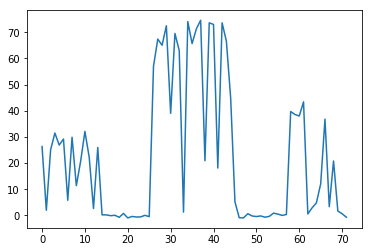

In [25]:
hoge = q_table[:,:,2].ravel()
plt.plot(hoge)
plt.show()

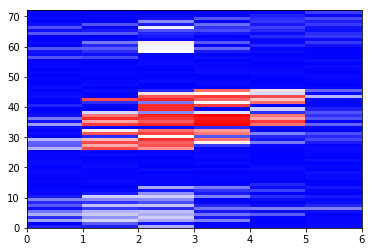

In [26]:
hoge = q_table.transpose((2,0,1,3,4))
fuga = hoge.reshape((hoge.shape[0],-1))
plt.pcolor( fuga.T, cmap='bwr' )
plt.show()

In [43]:
    bins_pos = bins(-2.4, 2.4, nb_pos)
    bins_vel = bins(-3.0, 3.0, nb_vel)
    bins_ang = bins(-0.5, 0.5, nb_ang)
    bins_omg = bins(-2.0, 2.0, nb_omg)
    print(bins_ang)

[-0.35714286 -0.21428571 -0.07142857  0.07142857  0.21428571  0.35714286]


In [46]:
import math
math.radians(12)

0.20943951023931956

In [1]:
'''
https://medium.com/@tuzzer/cart-pole-balancing-with-q-learning-b54c6068d947
''' 
import gym
import numpy as np
import random
import math
from time import sleep
from __future__ import division

## Initialize the "Cart-Pole" environment
env = gym.make('CartPole-v0')

## Defining the environment related constants

# Number of discrete states (bucket) per state dimension
NUM_BUCKETS = (1, 1, 6, 3)  # (x, x', theta, theta')
# Number of discrete actions
NUM_ACTIONS = env.action_space.n # (left, right)
# Bounds for each discrete state
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))
STATE_BOUNDS[1] = [-0.5, 0.5]
STATE_BOUNDS[3] = [-math.radians(50), math.radians(50)]
# Index of the action
ACTION_INDEX = len(NUM_BUCKETS)

## Creating a Q-Table for each state-action pair
q_table = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,))

## Learning related constants
MIN_EXPLORE_RATE = 0.01
MIN_LEARNING_RATE = 0.1

## Defining the simulation related constants
NUM_EPISODES = 1000
MAX_T = 250
STREAK_TO_END = 120
SOLVED_T = 199
DEBUG_MODE = False

def simulate():

    ## Instantiating the learning related parameters
    learning_rate = get_learning_rate(0)
    explore_rate = get_explore_rate(0)
    discount_factor = 0.99  # since the world is unchanging

    num_streaks = 0

    for episode in range(NUM_EPISODES):

        # Reset the environment
        obv = env.reset()

        # the initial state
        state_0 = state_to_bucket(obv)

        for t in range(MAX_T):
            env.render()

            # Select an action
            action = select_action(state_0, explore_rate)

            # Execute the action
            obv, reward, done, _ = env.step(action)

            # Observe the result
            state = state_to_bucket(obv)

            # Update the Q based on the result
            best_q = np.amax(q_table[state])
            q_table[state_0 + (action,)] += learning_rate*(reward + discount_factor*(best_q) - q_table[state_0 + (action,)])

            # Setting up for the next iteration
            state_0 = state

            # Print data
            if (DEBUG_MODE):
                print("\nEpisode = %d" % episode)
                print("t = %d" % t)
                print("Action: %d" % action)
                print("State: %s" % str(state))
                print("Reward: %f" % reward)
                print("Best Q: %f" % best_q)
                print("Explore rate: %f" % explore_rate)
                print("Learning rate: %f" % learning_rate)
                print("Streaks: %d" % num_streaks)

                print("")

            if done:
               print("Episode %d finished after %f time steps" % (episode, t))
               if (t >= SOLVED_T):
                   num_streaks += 1
               else:
                   num_streaks = 0
               break

            #sleep(0.25)

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > STREAK_TO_END:
            break

        # Update parameters
        explore_rate = get_explore_rate(episode)
        learning_rate = get_learning_rate(episode)


def select_action(state, explore_rate):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = np.argmax(q_table[state])
    return action


def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(1, 1.0 - math.log10((t+1)/25)))

def get_learning_rate(t):
    return max(MIN_LEARNING_RATE, min(0.5, 1.0 - math.log10((t+1)/25)))

def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)


simulate()


Episode 0 finished after 13.000000 time steps
Episode 1 finished after 9.000000 time steps
Episode 2 finished after 12.000000 time steps
Episode 3 finished after 16.000000 time steps
Episode 4 finished after 45.000000 time steps
Episode 5 finished after 15.000000 time steps
Episode 6 finished after 13.000000 time steps
Episode 7 finished after 15.000000 time steps
Episode 8 finished after 14.000000 time steps
Episode 9 finished after 23.000000 time steps
Episode 10 finished after 10.000000 time steps
Episode 11 finished after 17.000000 time steps
Episode 12 finished after 11.000000 time steps
Episode 13 finished after 38.000000 time steps
Episode 14 finished after 10.000000 time steps
Episode 15 finished after 20.000000 time steps
Episode 16 finished after 17.000000 time steps
Episode 17 finished after 10.000000 time steps
Episode 18 finished after 13.000000 time steps
Episode 19 finished after 21.000000 time steps
Episode 20 finished after 13.000000 time steps
Episode 21 finished afte

Episode 173 finished after 199.000000 time steps
Episode 174 finished after 199.000000 time steps
Episode 175 finished after 199.000000 time steps
Episode 176 finished after 199.000000 time steps
Episode 177 finished after 199.000000 time steps
Episode 178 finished after 199.000000 time steps
Episode 179 finished after 199.000000 time steps
Episode 180 finished after 199.000000 time steps
Episode 181 finished after 199.000000 time steps
Episode 182 finished after 199.000000 time steps
Episode 183 finished after 199.000000 time steps
Episode 184 finished after 199.000000 time steps
Episode 185 finished after 199.000000 time steps
Episode 186 finished after 199.000000 time steps
Episode 187 finished after 199.000000 time steps
Episode 188 finished after 199.000000 time steps
Episode 189 finished after 199.000000 time steps
Episode 190 finished after 199.000000 time steps
Episode 191 finished after 199.000000 time steps
Episode 192 finished after 199.000000 time steps
Episode 193 finished